## Import Modules

In [1]:
import docx
from docx import Document

import pandas as pd
import numpy as np
from collections import defaultdict

from scipy.spatial import distance
from scipy.cluster import hierarchy

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

## Read Data in Docx Format

In [2]:
document = Document('datasets/data.docx')
table = document.tables[1]

### Convert Docx Table to Dataframe

In [3]:
data = np.array([
    [cell.text for cell in row.cells]
    for row in table.rows[4:]
])
df = pd.DataFrame(
    data=data, 
    columns=['region', 'turnover', 'first', 'second', 'third']
)
df.set_index('region', inplace=True)

df = df.applymap(
    lambda x: x.replace(',', '.')
).astype(float)

In [4]:
df

,turnover,first,second,third
region,,,,
Вінницька,18287.8,85.0,103.3,98.5
Волинська,13755.0,85.0,95.0,96.4
Дніпропетровська,51951.8,80.1,103.7,99.1
Донецька2,19145.0,29.3,87.8,61.2
Житомирська,15879.1,87.3,101.7,99.7
Закарпатська,13672.4,85.5,103.4,98.4
Запорізька,27131.5,82.1,100.8,98.0
Івано-Франківська,17993.8,84.9,101.0,99.8
Київська,28775.5,86.6,104.8,96.8


## EDA

### Retail Turnover in different Ukrainian Regions

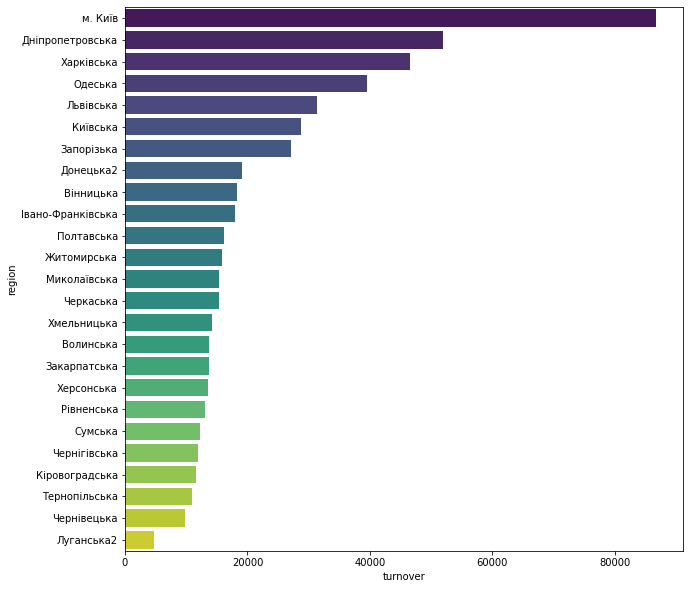

In [5]:
plt.figure(figsize=(10, 10))
sns.barplot(
    x=df.turnover,
    y=df.index,
    order=df.sort_values('turnover', ascending=False).index,
    palette='viridis'
)
plt.show()

### How does Turnover depend on Rate of Change?

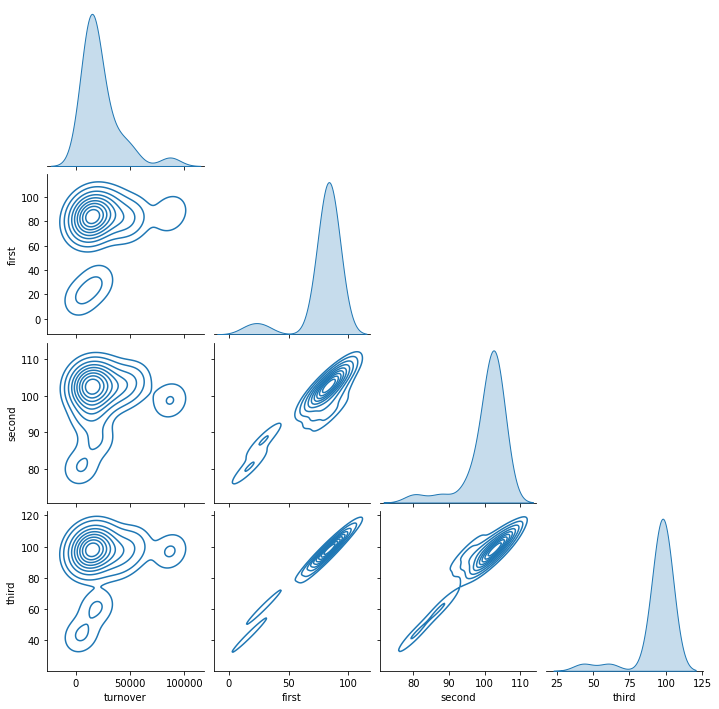

In [6]:
sns.pairplot(df, corner=True, kind='kde')

## Hierarchical Clustering

### Visualize Data

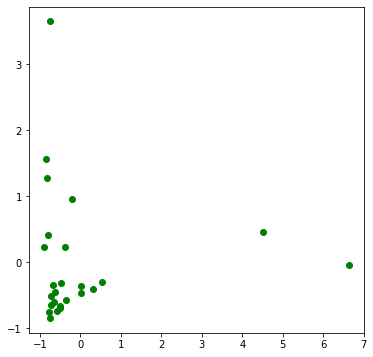

In [7]:
scaler = preprocessing.StandardScaler()
norm_df = scaler.fit_transform(df)

pca = decomposition.PCA(n_components=2, random_state=42)
x, y = pca.fit_transform(norm_df).T

plt.figure(figsize=(6, 6));
plt.scatter(x=x, y=y, color='green')

### Compute Distances

In [8]:
metrics = ['euclidean', 'seuclidean', 'cityblock', 'mahalanobis', 'minkowski', 'chebyshev']
n_metrics = len(metrics)

In [9]:
pw_distances = {
    metric: distance.pdist(
        X=norm_df,
        metric=metric, 
        **({'p': 4} if metric == 'minkowski' else dict())
    )
    for metric in metrics
}

#### Visualize Distances

In [10]:
def plot_distance_matrix(metric: str) -> None:
    plt.figure(figsize=(16, 16))
    
    matrix = distance.squareform(pw_distances[metric])
    sns.heatmap(matrix, annot=True)

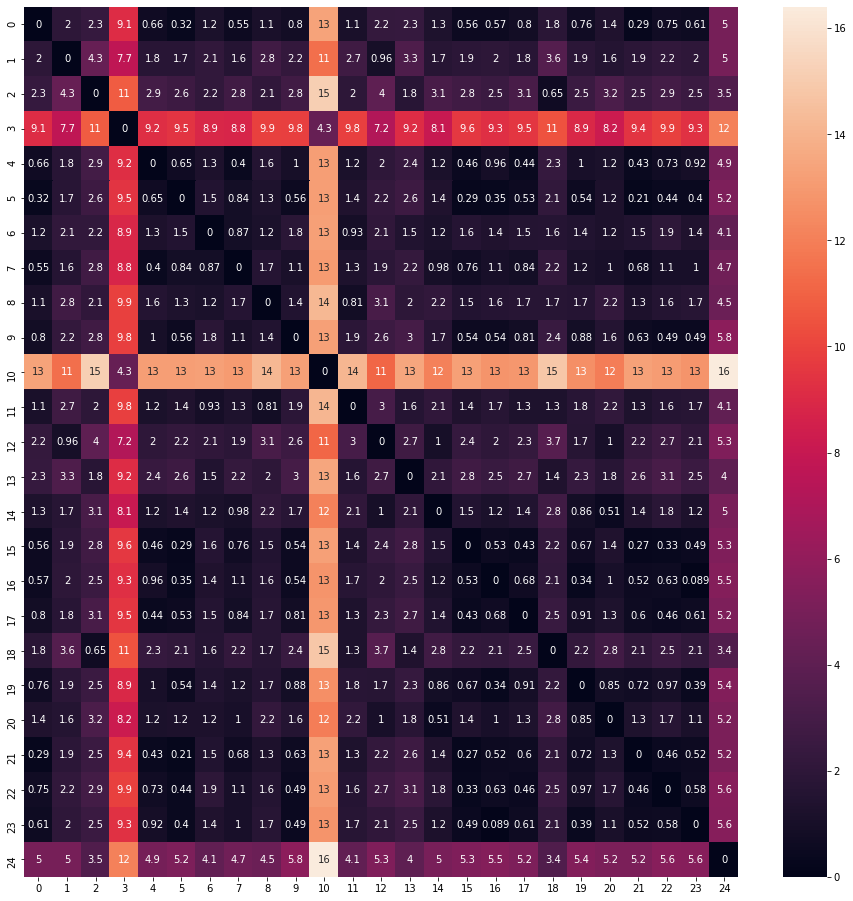

In [11]:
plot_distance_matrix('cityblock')

### Clusterize Data and Compute Cophenet Correlation Coefficients

In [12]:
methods = ['single', 'complete', 'average', 'centroid', 'median']
n_methods = len(methods)

In [13]:
cophenets = np.zeros((n_metrics, n_methods))
clustereds = defaultdict(dict)

for didx, (metric, pw_distance) in enumerate(pw_distances.items()):
    for lidx, method in enumerate(methods):
        
        clustered = hierarchy.linkage(pw_distance, method)
        cophenet = hierarchy.cophenet(clustered, pw_distance)[0]
        
        clustereds[metric][method] = clustered
        cophenets[didx][lidx] = cophenet

cophenet_df = pd.DataFrame(cophenets, metrics, methods)

In [14]:
cophenet_df

,single,complete,average,centroid,median
euclidean,0.959446,0.948965,0.967370,0.966056,0.962634
seuclidean,0.959446,0.948965,0.967370,0.966056,0.962634
cityblock,0.962833,0.948201,0.966319,0.966131,0.962190
mahalanobis,0.864786,0.784976,0.913539,0.917337,0.887777
minkowski,0.937490,0.938741,0.964046,0.962942,0.948128
chebyshev,0.911013,0.925260,0.961801,0.961685,0.942379


### Find Best and Worst (Methods + Metrics)

In [15]:
pd.DataFrame([cophenet_df.idxmin(), cophenet_df.min()])

,single,complete,average,centroid,median
0,mahalanobis,mahalanobis,mahalanobis,mahalanobis,mahalanobis
1,0.864786,0.784976,0.913539,0.917337,0.887777


In [16]:
pd.DataFrame([cophenet_df.idxmax(), cophenet_df.max()])

,single,complete,average,centroid,median
0,cityblock,euclidean,euclidean,cityblock,euclidean
1,0.962833,0.948965,0.96737,0.966131,0.962634


### Dendrogram For Clustering

In [17]:
best_metric = 'euclidean'
best_method = 'average'
best_clustered = clustereds[best_metric][best_method]

In [18]:
def pretty_dendrogram(metric: str, method: str, **kwargs) -> dict[str, np.ndarray]:
    plt.figure(figsize=(12, 15))

    max_depth = kwargs.pop('max_depth', None)
    if max_depth:
        kwargs['color_threshold'] = max_depth
    anot_height = kwargs.pop('annot_height', 0.5)
    
    dn = hierarchy.dendrogram(
        Z=clustereds[metric][method],
        labels=df.index, **kwargs
    )

    icoords = dn['icoord']
    dcoords = dn['dcoord']
    colors = dn['color_list']

    for icoord, dcoord, color in zip(icoords, dcoords, colors):
        xx = np.sum(icoord[1:3]) / 2
        yy = dcoord[1]
        if yy < anot_height: continue
        plt.plot(xx, yy, marker='o', color=color)
        plt.annotate(
            text='{:.3f}'.format(yy),
            xy=(xx, yy),
            xytext=(0, -5),
            textcoords='offset points',
            va='top',
            ha='center'
        )
    if max_depth:
        plt.axhline(y=max_depth, color='black')
        
    plt.title(f'''
        Metric: {metric.title()} 
        Method: {method.title()}
    ''')
    return dn

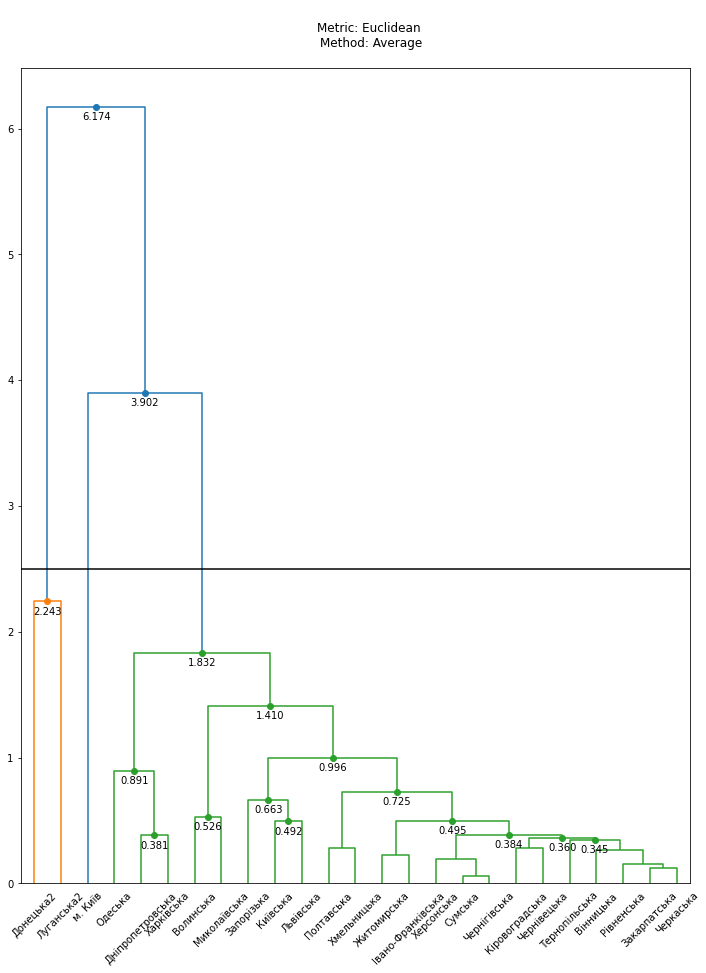

In [19]:
ddata = pretty_dendrogram(
    metric=best_metric,
    method=best_method,
    max_depth=2.5, 
    annot_height=0.3
)

### Elbow Method

In [20]:
def elbow_method(metric: str, method: str, min_clusters: int = 1, max_clusters: int = 10) -> int:
    clustered = clustereds[metric][method]
    
    n_clusters = np.arange(min_clusters, max_clusters)
    inertias = np.zeros_like(n_clusters)
    
    for idx, num in enumerate(n_clusters):
        targets = hierarchy.fcluster(
            clustered, num, 'maxclust'
        )
        result = pd.DataFrame(norm_df)
        result['target'] = targets
        
        centroids = result.groupby('target').agg(np.mean).values
        inertia = np.square(
            norm_df - centroids[targets - 1]).sum()
        
        inertias[idx] = inertia
    
    def plot_elbow() -> None:
        plt.figure(figsize=(8, 8))
        
        plt.xlabel('Num Clusters')
        plt.ylabel('Inertia')
        
        plt.plot(n_clusters, inertias, '-ro')
    
    plot_elbow()
    return inertias

array([100,  32,  18,  15,   7,   4,   2,   2,   1])

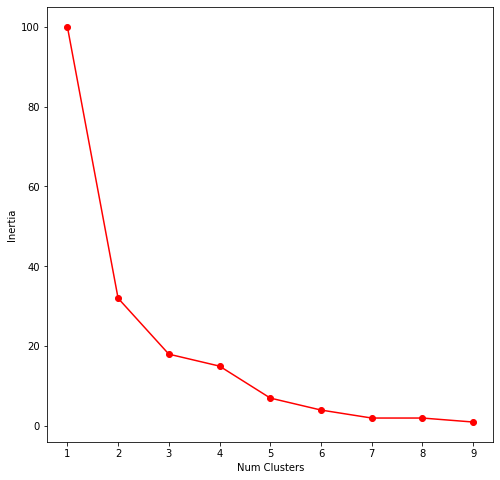

In [21]:
elbow_method(best_metric, best_method)

### Split on Clusters

In [29]:
n_clusters = 6

In [30]:
targets = hierarchy.fcluster(
    Z=best_clustered,
    t=n_clusters, 
    criterion='maxclust'
)

### Compute Statistics

In [31]:
target_df = pd.DataFrame(norm_df, columns=df.columns)
target_df['target'] = targets

#### Centroids

In [32]:
centroids = target_df.groupby('target').agg(np.mean).values
centroids

array([[-0.18672619, -2.95899097, -2.32682106, -2.56999486],
       [-1.01540629, -3.68136589, -3.68818063, -3.9728647 ],
       [ 1.35626204,  0.15140023,  0.42655933,  0.180884  ],
       [-0.44879309,  0.16931035, -0.88267611,  0.07116234],
       [-0.33340018,  0.31821019,  0.40130889,  0.33117502],
       [ 3.69873554,  0.43796219, -0.32157521,  0.22790757]])

#### Distances Between Centroids

In [33]:
distance.pdist(centroids)

array([2.24273938, 5.2157247 , 4.34927743, 5.15955815, 6.20365799,
       7.38238579, 6.27485206, 7.19099601, 8.25666499, 2.23263994,
       1.70470201, 2.47612931, 1.3235221 , 4.19685249, 4.09947369])

#### Silhouette Score

In [34]:
silhouette_score(
    X=distance.squareform(pw_distances[best_metric]),
    labels=targets
)

0.499313125078286

### Visualize Clustered Data

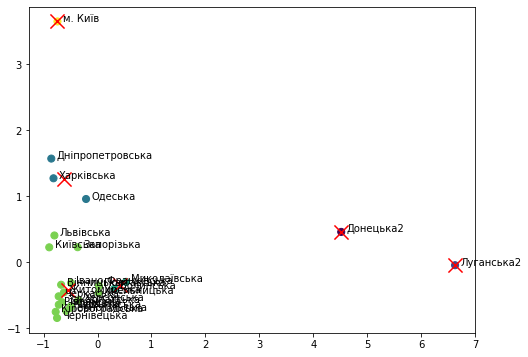

In [38]:
target2d = pd.DataFrame({'x': x, 'y': y, 'target': targets})

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=targets, s=50)

for idx, label in enumerate(df.index):
    plt.annotate(
        text=label, 
        xy=(x[idx] + 0.1, y[idx])
    )
plt.scatter(
    x='x', y='y', s=200, 
    color='r', 
    marker='x', 
    data=target2d.groupby('target').agg('mean')
)